# Predicting Heart Disease 

**Date updated:** 10/22/23  

**Data source:** [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)  
  
  
  
This project aims to use a basic k-NN algorithm to predict whether or not a patient has heart disease. The dataset includes personal patient informaiton (age, sex, etc.) and their medical information (diabetes status, chest pain status, etc.). The target variable is a binary variable indicating whether or not a patient has heart disease. 

Note: This is a guided project through Dataquest.io.

## 0. Import libraries

In [12]:
import pandas as pd

# Modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## 1. Exploring the data

In [13]:
heart_disease_df = pd.read_csv('heart_disease_prediction.csv')

print(heart_disease_df.head(), '\n')
print("Number of observations and features: ", heart_disease_df.shape)

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0   

Number of observations and features:  (918, 12)


### 1a. Numerical variables

In [14]:
heart_disease_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


#### Notes:
- 1. There are 918 patients in the dataset and none have missing info for these numerical vars. 
- 2. The average patient age is 53.
- 3. At least one patient has a cholesterol value of 0; need to investigate to see if this could indicate missing values. 
- 4. At least one patient has a RestingBP value of 0; need to investigate to see if this could indicate missing values. 


In [15]:
print('N with Cholesterol of 0: ', heart_disease_df[heart_disease_df['Cholesterol'] == 0].shape[0])
print('N with RestingBP of 0: ', heart_disease_df[heart_disease_df['RestingBP'] == 0].shape[0])

N with Cholesterol of 0:  172
N with RestingBP of 0:  1


#### Notes about Cholesterol and RestingBP == 0:
- 1. 172 observations have cholesterol listed as 0,  which is a lot. Need to look into whether that's a valid number or whether it could indicate missing info. 
- 2. Only one obs has RestingBP of 0. 

Next, let's check the distribution of Cholesterol and RestingBP patients after excluding 0 values. 

In [16]:
print('Cholesterol stats: \n', heart_disease_df.loc[heart_disease_df['Cholesterol'] != 0, 'Cholesterol'].describe(), end = '\n\n')
print('RestingBP stats: \n', heart_disease_df.loc[heart_disease_df['RestingBP'] != 0, 'RestingBP'].describe())

Cholesterol stats: 
 count    746.000000
mean     244.635389
std       59.153524
min       85.000000
25%      207.250000
50%      237.000000
75%      275.000000
max      603.000000
Name: Cholesterol, dtype: float64

RestingBP stats: 
 count    917.000000
mean     132.540894
std       17.999749
min       80.000000
25%      120.000000
50%      130.000000
75%      140.000000
max      200.000000
Name: RestingBP, dtype: float64


#### Notes:
Looks like Cholesterol and RestingBP = 0  data are fillers for missing info. 

### 1b. Categorical Variables

In [17]:
print(heart_disease_df['Sex'].value_counts(dropna=False))

print(heart_disease_df['ChestPainType'].value_counts(dropna=False))

print(heart_disease_df['RestingECG'].value_counts(dropna=False))

print(heart_disease_df['ExerciseAngina'].value_counts(dropna=False))

print(heart_disease_df['ST_Slope'].value_counts(dropna=False))

M    725
F    193
Name: Sex, dtype: int64
ASY    496
NAP    203
ATA    173
TA      46
Name: ChestPainType, dtype: int64
Normal    552
LVH       188
ST        178
Name: RestingECG, dtype: int64
N    547
Y    371
Name: ExerciseAngina, dtype: int64
Flat    460
Up      395
Down     63
Name: ST_Slope, dtype: int64


#### Notes:

- 1. There are no missing values for the categorical data.
- 2. The dataset has a very imbalanced in terms of gender. Almost 80% of observations are male. This could pose a bias in our models.
- 3. There don't seem to be any categories indicating missing information.

### 1c. Check for missing values

In [18]:
print(heart_disease_df.isna().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


No missing values in the dataset. 

### 1d. Descriptive charts of key variables

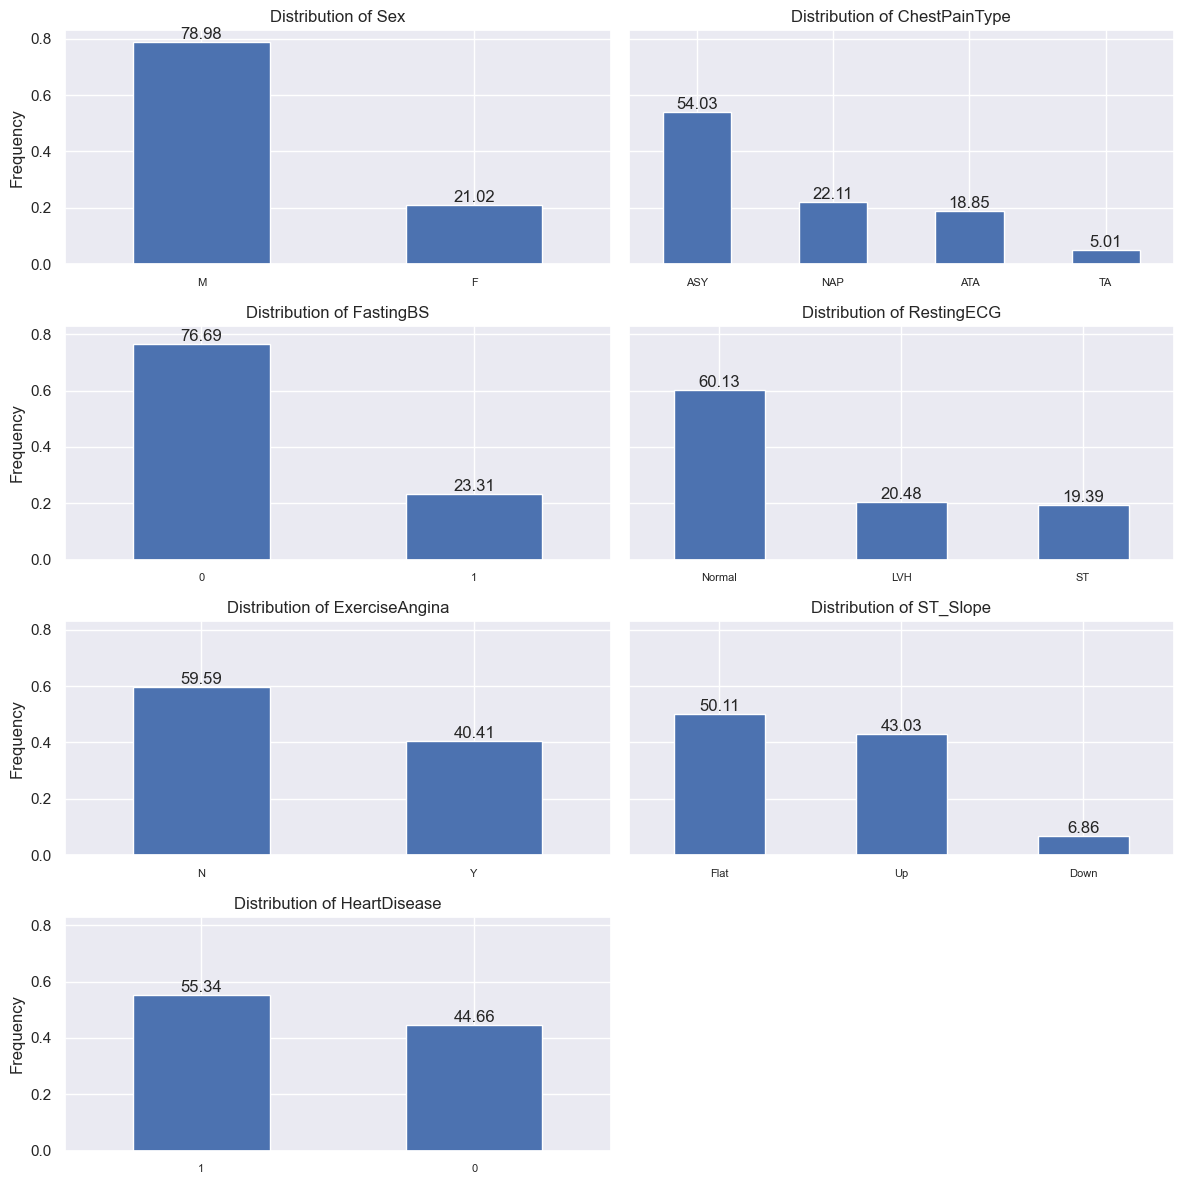

In [19]:
fig, axs = plt.subplots(nrows = 4, ncols = 2, sharey=True, figsize = (12, 12))
fig.subplots_adjust(hspace=0.5)

cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']

fig.delaxes(axs[3, 1])

for ax, col in zip(axs.flatten(), cat_cols):
    #plot bars, add title, fix axes
    val_counts = heart_disease_df[col].value_counts(normalize=True)
    val_counts.plot(ax = ax, kind = 'bar')
    ax.set_title(f'Distribution of {col}')
    ax.tick_params(axis='x', labelsize=8, labelrotation=0)
    ax.set_ylabel('Frequency')
    s
    #value labels
    for i, v in enumerate(val_counts):
        v_round = round(v*100, 2)
        ax.text(i, v, str(v_round), ha='center', va='bottom')
        

plt.tight_layout()
plt.show()



#### Notes:
- 1. The dataset is heavily skewed male (almost 80% male).
- 2. Not as skewed in the share of patients with heart disease - 55% have it.


### 1e. Group observations by Heart Disease Status

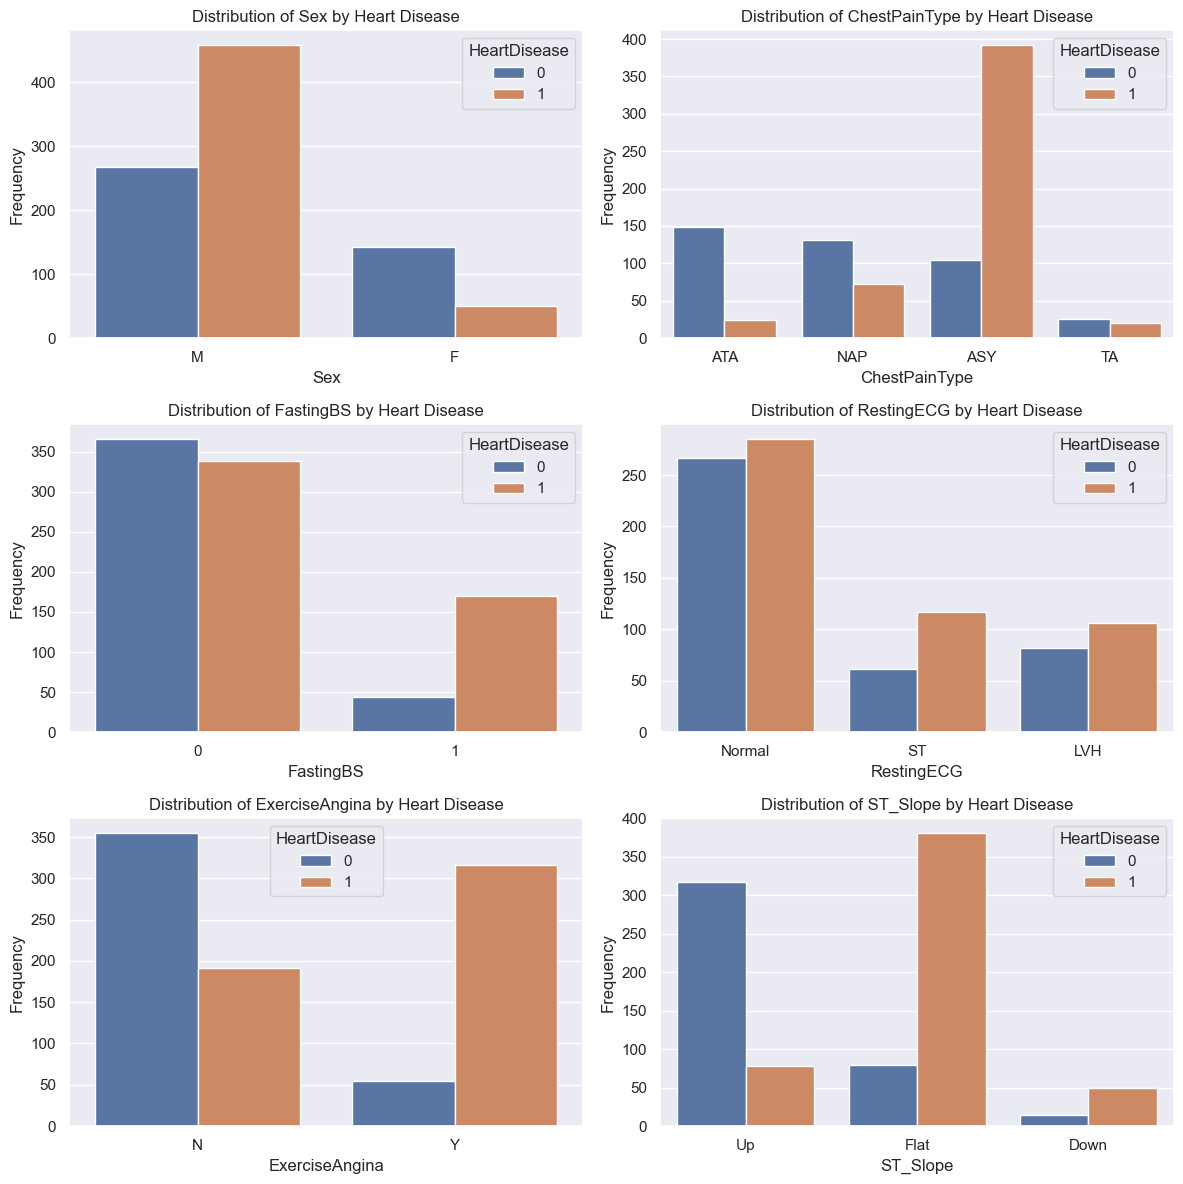

In [20]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
fig.subplots_adjust(hspace=0.5)

cat_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

for ax, col in zip(axs.flatten(), cat_cols):
    sns.countplot(data=heart_disease_df, x=col, hue='HeartDisease', ax=ax)
    ax.set_title(f'Distribution of {col} by Heart Disease')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Notes:
- 1. Heart disease prevalence is much higher in men than in women. More than half the men have heart disease, but less than half the women do. 
- 2. Heart disease is most prevalent in those  with ChestPainType = ASY (which stands for Asymptomatic - that doesn't seem to make sense?)
- 3.  Heart disease is much more common among those  whose ST_slopes  are flat and those who have Exercise-induced Angina, as well as those with fasting Blood Sugar higher than 120.

In [21]:
hd_copy = heart_disease_df.copy()

#Group data by HD status
hd_groups = hd_copy.groupby('HeartDisease')

#Calculate median ages by group
median_ages = hd_groups['Age'].median()

#Calculate pct of HD patients who are male and over 50
#Note: Group 1 is patients with HD, group 0 is patients without HD
males_over_50 = hd_groups.get_group(1).loc[(hd_copy['Age'] > 50) & (hd_copy['Sex'] == 'M'), :]
pct_over_50 = len(males_over_50)/len(hd_groups.get_group(1))*100

print(f"Percent of HD patients who are male and over 50: {pct_over_50:.2f}%")                                          
print('Median age of patients with HD: ', median_ages[1])



Percent of HD patients who are male and over 50: 67.72%
Median age of patients with HD:  57.0


## 2. Cleaning up  missing data (i.e. 0 values in Cholesterol and RestingBP)

- 1. From above, we know there are 172 rows with Cholesterol ==  0. Too many to drop so we will have to impute. 

- 2. From above, we know there is only 1 row with RestingBP == 0, so we can drop that one.

### 2a. Cholesterol Imputation using median of HeartDisease groups

Method:
- Define an impute_cholesterol function which takes in a group of rows from a dataframe, calculates the median cholesterol value for the group, and replaces any 0 value with the median. 
- Use groupby on the original dataframe to split into heart disease status groups and apply the above function to each group. Save as a new dataframe. 

In [22]:
hd_copy = heart_disease_df.copy()

def impute_cholesterol(group):
    # Calculate the median cholesterol level for the current group
    median_chol = group['Cholesterol'].median()
    # Replace 0 values with the calculated median within the group
    group['Cholesterol'].replace(0, median_chol, inplace=True)
    return group

hd_imputed_1  = hd_copy.groupby('HeartDisease', group_keys=False).apply(impute_cholesterol).reset_index(drop=True)

#Print first 10 patients who originally had Cholesterol = 0 to make sure imputation worked
print('Preview of imputed data for patients with Cholesterol =  0: \n', hd_imputed_1.loc[hd_copy['Cholesterol'] == 0, ['Cholesterol', "HeartDisease"]].head(10))


Preview of imputed data for patients with Cholesterol =  0: 
      Cholesterol  HeartDisease
293          217             1
294          217             1
295          217             1
296          217             1
297          217             1
298          217             1
299          217             1
300          217             1
301          227             0
302          217             1


### 2b. Cholesterol Imputation using median of more specific groups
Method:
- First create age_range, which bins patients into age groups. 
- Use groupby on the original dataframe to split into heart disease status, age_range, Sex, and RestingECG groups and apply the above function to each group. Save as a new dataframe. 

In [23]:
hd_copy['age_range'] = pd.cut(hd_copy['Age'], 
                                      [0, 30, 40, 50, 60, 70, 100],
                                      labels = ['Below 30', '30s', '40s', '50s', '60s', '70 or above'],
                                      right=False)


# Group the data by 'Age', 'Sex', and 'HeartDisease' and apply the imputation function
hd_imputed_2 = hd_copy.groupby(['HeartDisease', 'Sex', 'age_range', 'RestingECG'], group_keys=False).apply(impute_cholesterol).reset_index(drop=True)


#Print values to confirm that the imputation and replacement worked
print(hd_imputed_2.loc[hd_copy['Cholesterol'] == 0, ['Cholesterol', 'HeartDisease', 'Sex', 'age_range', 'RestingECG']].head(30))




     Cholesterol  HeartDisease Sex    age_range RestingECG
293        177.0             1   M          60s     Normal
294        197.0             1   M          30s     Normal
295        177.0             1   M          60s     Normal
296        202.5             1   M          50s     Normal
297        213.0             1   M          50s         ST
298        202.5             1   M          50s     Normal
299         86.0             1   M          40s         ST
300        177.0             1   M          60s     Normal
301        199.0             0   M          50s         ST
302        202.5             1   M          50s     Normal
303          0.0             1   F          60s         ST
304        202.5             1   M          50s     Normal
305        276.5             1   F          50s     Normal
306        202.5             1   M          50s     Normal
307        199.0             0   M          50s         ST
308        202.5             1   M          50s     Norm

### Note:

There are a few observations that still have Cholesterol = 0, probably because there were no other patients with valid Chol values in these patients' subgroups.

In [24]:
print('N with Cholesterol of 0: ', hd_imputed_2[hd_imputed_2['Cholesterol'] == 0].shape[0])

N with Cholesterol of 0:  4


##### There are only 4 such observations so I think we can just drop them rather than widen the subgroups. 

### 2c. Create final dataset

In [25]:
hd_imputed = hd_imputed_2[(hd_imputed_2['Cholesterol'] !=  0 ) & (hd_imputed_2['RestingBP'] != 0)]

print(hd_imputed.shape)
print(hd_copy.shape)

(913, 13)
(918, 13)


## 3. Feature Selection

- 1. First create dummies for string categorical vars.
- 2. Explore key features 

### 3a. Create dummy variables for categorical vars

In [26]:
vars_for_dummies = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

hd_imputed =  pd.get_dummies(data=hd_imputed, columns=vars_for_dummies, drop_first=True) 
print(hd_imputed.head())


   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140        289.0          0    172      0.0             0   
1   49        160        180.0          0    156      1.0             1   
2   37        130        283.0          0     98      0.0             0   
3   48        138        214.0          0    108      1.5             1   
4   54        150        195.0          0    122      0.0             0   

  age_range  Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0       40s      1                  1                  0                 0   
1       40s      0                  0                  1                 0   
2       30s      1                  1                  0                 0   
3       40s      0                  0                  0                 0   
4       50s      1                  0                  1                 0   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0       

### 3b. Explore correlations 

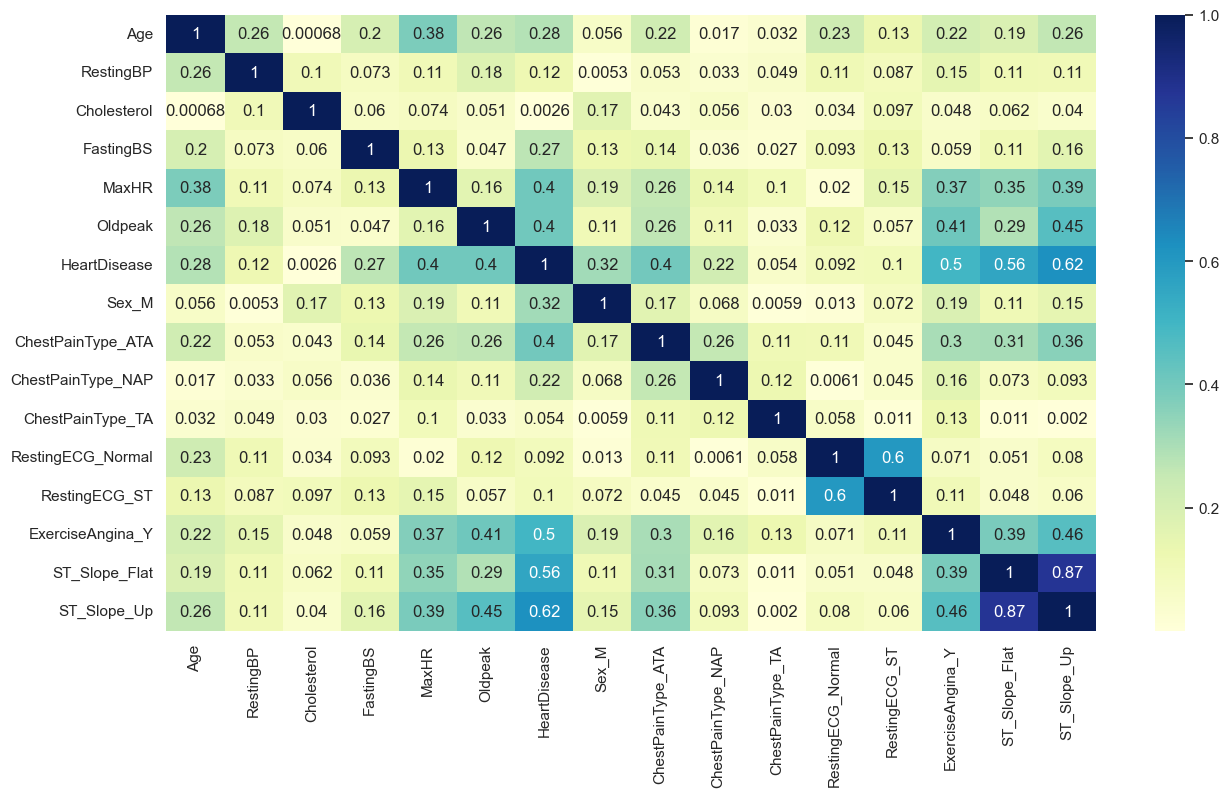

In [27]:
corrs = hd_imputed.corr(numeric_only=True)

plt.figure(figsize=(15,8))
sns.heatmap(corrs.abs(), annot=True, cmap='YlGnBu')
plt.show()


#### Notes:

HeartDisease is highly correlated with Age (0.28), Sex (0.32), ChestPainType (up to -0.4), ExerciseAngina (0.5), ST_Slope (-0.6 to 0.6), RestingBP (0.12), and FastingBS (0.27), MaxHR (-0.4), and Oldpeak (0.4).

Based on these, I'm selecting features that have a abs(r) above 0.3:
- Sex_M
- MaxHR
- Oldpeak
- ChestPainType_ATA
- ExerciseAngina_Y
- ST_Slope_Flat
- ST_Slope_Up


## 4. Building a classifier

### 4a. Split into Training, Validation, and Test Datasets:

I've chosen a test size of 0.15, which means the validation and test sets will each contain 15% of the original data and the training set will use 70% of the original data. 

In [28]:
features = ['Sex_M', 'MaxHR',  'Oldpeak', 'ChestPainType_ATA', 
                'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']
X = hd_imputed.drop(['HeartDisease'], axis=1)
y = hd_imputed['HeartDisease']

#Generate validation and training sets - using 15% of the data for each.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=777)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.15*X.shape[0]/X_train.shape[0],
                                                    random_state=777)


### 4b. First, test one feature at a time:

In [29]:
#Loop through features and build k-NN model for each. Add accuracy score of each to a dictionary.
accuracies = {}
for f in features:
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train[[f]], y_train)
    
    accuracies[f] = round(knn.score(X_val[[f]], y_val),2)

print('Model accuracies: \n', accuracies)                

Model accuracies: 
 {'Sex_M': 0.67, 'MaxHR': 0.59, 'Oldpeak': 0.62, 'ChestPainType_ATA': 0.43, 'ExerciseAngina_Y': 0.76, 'ST_Slope_Flat': 0.76, 'ST_Slope_Up': 0.43}


#### Notes:
The models with the highest accuracy are the ones using ExerciseAngina_Y and ST_Slope_Flat, with accuracies of 0.76. Makes sense, given that these features have the strongest correlations with HeartDisease. 

### 4c. Build a model with multiple features:

In [30]:
#Scale data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])
X_val_scaled = scaler.transform(X_val[features])

#Build model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_scaled, y_train)

#Evaluate model
accuracy = knn.score(X_val_scaled, y_val)
print('Model accuracy with all selected features and k=3: \n', f'{accuracy*100:.2f}%')



Model accuracy with all selected features and k=3: 
 83.94%


#### Notes:
This model performed better than our best model using one feature at a time, with an accuracy of 84%. Not too shabby! 

## 5. Model optimization

### 5a. Hyperparameter optimization

In [31]:
X = hd_imputed.drop(['HeartDisease'], axis=1)
y = hd_imputed['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=777)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[features])

#Create a dictionary of hyperparameters to test:
hyperparams = {'n_neighbors': range(1,20),
              'metric': ['minkowski', 'manhattan'],
              'weights': ['uniform', 'distance'], 
              }

#Initiate k-NN model
knn = KNeighborsClassifier()

#Use GridSearchCV
knn_grid = GridSearchCV(knn, hyperparams, scoring='accuracy')
grid_fit = knn_grid.fit(X_train_scaled, y_train)

best_score = knn_grid.best_score_
best_params = knn_grid.best_params_

print('Highest accuracy: ', best_score)
print('Best parameters: ', best_params)



Highest accuracy:  0.8479321753515302
Best parameters:  {'metric': 'manhattan', 'n_neighbors': 16, 'weights': 'uniform'}


#### Notes:
Looks like the best parameters are to use the manhattan distance metric with uniform weights and n_neighbors=16.

However, this model's accuracy is only slightly higher than our previous model with n_neighbors=3 (85% vs 84%).


### 5b. Test best model on the test set! 

In [32]:
X_test_scaled = scaler.transform(X_test[features])

test_predictions = knn_grid.best_estimator_.predict(X_test_scaled)
accuracy  = accuracy_score(y_test, test_predictions)

print(f'Model accuracy on the test set: {accuracy*100:.2f}%')



Model accuracy on the test set: 86.13%


#### Notes:
Not bad! Our model had an 86% accuracy on the test set. 

## 6. Summary

We used a k-Nearest Neighbors algorithm to predict whether or not a patient will have heart disease using a dataset of 918 patients and the following features:
- `Sex_M`
- `MaxHR`
- `Oldpeak`
- `ChestPainType_ATA`
- `ExerciseAngina_Y`
- `ST_Slope_Flat`
- `ST_Slope_Up`

Using a training set of 85% of the original data and using the closest 16 neighbors (identified using the Manhattan distance metric), we developed a model that had an **86% accuracy** in predicting heart disease! 

### Some caveats
Including `Sex_M` as a feature could present a bias because there are so few female patients in the dataset.  